In [1]:
import pickle
import numpy as np
from rul_calce_data import individual_battery_run 
from utility import cal_ttf

def rul_battery(t, y, name):
    # Calculate true TTF.
    threshold = .7*1.1
    true_ttf, idx_ttf = cal_ttf(t, y, threshold)
    t = t[:idx_ttf+10]
    y = y[:idx_ttf+10]
    T = len(t) # Number of time steps
    
    # Define the Parameters.
    # For the PF.
    sigma_u = np.array([1e-2, 1e-5, 1e-4, 1e-3])
    sigma_v = 1e-2
    Ns = 1e3
    # For the RUL prediction.
    max_ite = 60 # Maximun number of prediction states.
    max_RUL = 60 # RUL when not failure found.
    idx_start = 50
    step = 1
    idx_pred = np.arange(idx_ttf-idx_start, idx_ttf+step, step, dtype=int) # Index of the prediction instants.
    # Create the time.
    t_pred = np.arange(t[-1]+1, t[-1] + max_ite + 1, 1) 
    t_pred = np.concatenate((t, t_pred))
    
    xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, pf = individual_battery_run(t, y, sigma_u, sigma_v, Ns, threshold, idx_ttf, idx_pred, t_pred, max_ite, max_RUL)

    # Save the result.
    file_name = 'result_' + name + '.pickle'
    with open(file_name, 'wb') as f:
        pickle.dump([t, y, threshold, idx_ttf, idx_pred, true_ttf, max_RUL, 
            xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, t_pred,
            pf.particles, pf.w
        ], f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Run particle filtering to estimate the state variables.
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Directly read from the archived data.
with open('data_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

# CS2_37 test


In [3]:
from utility import drop_outlier_sw
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
df = data_all['CS2_35']
df1 = data_all['CS2_36']
df2 = data_all['CS2_38']


In [5]:
df1

,cycle,charging capacity,CCCT,CVCT,discharging capacity,SoH,resistance
0,1.0,1.168112,6763.869904,2277.979763,1.143918,0.826266,0.094061
1,2.0,1.150323,6671.683200,2212.998635,1.133807,0.825405,0.091628
2,3.0,1.158800,6666.933312,2204.373626,1.133413,0.825388,0.091628
3,4.0,1.158005,6662.682287,2201.186076,1.132829,0.825391,0.090817
4,5.0,1.156610,6656.650722,2225.592597,1.127033,0.816240,0.088546
...,...,...,...,...,...,...,...
971,972.0,0.162691,322.572668,2210.290723,0.155889,0.045849,0.120820
972,973.0,0.171415,326.197599,2211.853034,0.155896,0.045849,0.121520
973,974.0,0.176973,341.134758,2210.931269,0.165061,0.045853,0.120118
974,975.0,0.177631,351.212846,2213.009479,0.155890,0.045851,0.120118


In [6]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


<Axes: >

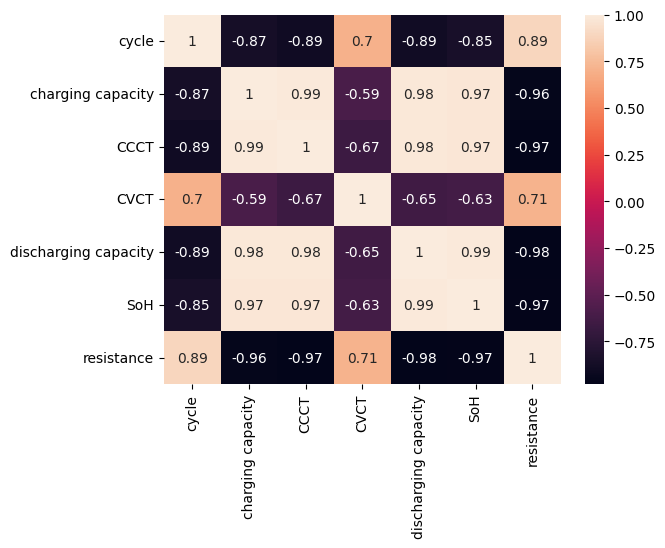

In [7]:
import seaborn as sns
sns.heatmap(df.corr(),annot=True)

In [8]:
df.fillna(method='ffill', inplace=True)
df1.fillna(method='ffill', inplace=True)
df2.fillna(method='ffill', inplace=True)

In [9]:
X = df['discharging capacity']
X1 = df1['discharging capacity']
X2 = df2['discharging capacity']


In [10]:
X

0      1.137444
1      1.126385
2      1.126160
3      1.125966
4      1.118508
         ...   
931    0.311687
932    0.302522
933    0.302530
934    0.302530
935    0.293367
Name: discharging capacity, Length: 936, dtype: float64

In [11]:
X1

0      1.143918
1      1.133807
2      1.133413
3      1.132829
4      1.127033
         ...   
971    0.155889
972    0.155896
973    0.165061
974    0.155890
975    0.165059
Name: discharging capacity, Length: 976, dtype: float64

In [12]:
idx = drop_outlier_sw(X,20)
idx1 = drop_outlier_sw(X1,20)
idx2 = drop_outlier_sw(X2,20)


x1 = X.iloc[idx]
x2 = X1.iloc[idx1]
x3 = X2.iloc[idx2]

In [13]:
x1

1      1.126385
2      1.126160
3      1.125966
4      1.118508
5      1.117210
         ...   
916    0.247524
917    0.357558
918    0.357541
919    0.348375
920    0.339218
Name: discharging capacity, Length: 873, dtype: float64

In [14]:
x2

1      1.133807
2      1.133413
3      1.132829
4      1.127033
5      1.126712
         ...   
955    0.174237
956    0.165067
957    0.165063
958    0.165059
960    0.165073
Name: discharging capacity, Length: 916, dtype: float64

X1.to_csv('X1.csv')
X2.to_csv('X2.csv')
X3.to_csv('X3.csv')

In [15]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

In [16]:
X1 = pd.DataFrame(x1)
X1 = ss.fit_transform(X1)
X1 = pd.DataFrame(X1)

X2 = pd.DataFrame(x2)
X2 = ss.fit_transform(X2)
X2 = pd.DataFrame(X2)

X3 = pd.DataFrame(x3)
X3 = ss.fit_transform(X3)
X3 = pd.DataFrame(X3)

X1 = X1[:832]
X2 = X2[:832]
X3 = X3[:832]

In [17]:
X1 = np.array(X1)
X2 = np.array(X2)
X3 = np.array(X3)

In [18]:
X1

array([[1.00000000e+00],
       [9.99744339e-01],
       [9.99523476e-01],
       [9.91037464e-01],
       [9.89560994e-01],
       [9.85628034e-01],
       [9.68633978e-01],
       [9.65632572e-01],
       [9.58453737e-01],
       [9.55849417e-01],
       [9.64002699e-01],
       [9.64936171e-01],
       [9.64782144e-01],
       [9.64543544e-01],
       [9.64066601e-01],
       [9.63657920e-01],
       [9.63202021e-01],
       [9.62538902e-01],
       [9.61710327e-01],
       [9.57296043e-01],
       [9.56758682e-01],
       [9.56318964e-01],
       [9.55902580e-01],
       [9.55452600e-01],
       [9.54959008e-01],
       [9.54501527e-01],
       [9.43195015e-01],
       [9.33888059e-01],
       [9.26594193e-01],
       [9.24977241e-01],
       [9.23407478e-01],
       [9.34059087e-01],
       [9.35575760e-01],
       [9.25883848e-01],
       [9.16277209e-01],
       [9.14790222e-01],
       [9.13984125e-01],
       [9.12826382e-01],
       [9.23515771e-01],
       [9.24984435e-01],


In [19]:
X1=X1.flatten()
X2=X2.flatten()
X3=X3.flatten()

In [20]:
len(X3)

1031

In [21]:
X1 = pd.DataFrame(X1[:832])
X2 = pd.DataFrame(X2[:864])
X3 = pd.DataFrame(X3[:928])



In [22]:
index_x1 = np.arange(0,len(X1))
index_x2 = np.arange(0,len(X2))
index_x3 = np.arange(0,len(X3))

In [23]:
index_x1 = pd.DataFrame(index_x1)
index_x2 = pd.DataFrame(index_x2)
index_x3 = pd.DataFrame(index_x3)

In [24]:
X_1_ = pd.concat([index_x1,X1],axis=1,ignore_index=True)
X_2_ = pd.concat([index_x2,X2],axis=1,ignore_index=True)
X_3_ = pd.concat([index_x3,X3],axis=1,ignore_index=True)

In [25]:
x_1 = pd.DataFrame(X_1_)
x_2 = pd.DataFrame(X_2_)
x_3 = pd.DataFrame(X_3_)

In [26]:
x_2

,0,1
0,0,1.000000
1,1,0.999594
2,2,0.998990
3,3,0.993008
4,4,0.992676
...,...,...
859,859,0.151458
860,860,0.151451
861,861,0.151444
862,862,0.160922


In [27]:
x_2[0]

0        0
1        1
2        2
3        3
4        4
      ... 
859    859
860    860
861    861
862    862
863    863
Name: 0, Length: 864, dtype: int64

In [28]:
yyy = np.arange(0,len(X1))
yyy_1 = np.arange(0,len(X2))
yyy_2 = np.arange(0,len(X3))

In [29]:
import numpy as np
import math
from scipy.optimize import curve_fit

def my_func(x, a, b, c, d):
    return a*np.exp(b*x)+c*np.exp(d*x)

popt, pcov = curve_fit(my_func, yyy,X1[0],p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))
popt1, pcov1 = curve_fit(my_func, yyy_1,X2[0], p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))
popt2, pcov2 = curve_fit(my_func, yyy_2,X3[0], p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))



##x_hat, _ = curve_fit(degradation_mdl,xdata=t_data, ydata=y_data, p0=x0, bounds=bounds)


##x0 = np.array([1.1, -5e-5, -1.5e-3, .006])    
##bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01))



In [30]:
a,b,c,d= popt
popt

array([ 1.00000000e+00, -4.85220740e-04, -1.00000000e-03,  7.66522897e-03])

In [31]:
a1,b1,c1,d1 = popt1
popt1

array([ 1.00000000e+00, -3.90334201e-04, -4.54808956e-03,  5.70736503e-03])

In [32]:
a2,b2,c2,d2 = popt2
popt2

array([ 1.00000000e+00, -4.79575642e-04, -1.00000000e-03,  6.61956645e-03])

In [33]:
yyy_curve_fit = []

for x in yyy:
    yyy_curve_fit.append(a*np.exp(b*x)+c*np.exp(d*x))

yyy_curve_fit1 = []

for x in yyy_1:
    yyy_curve_fit1.append(a1*np.exp(b1*x)+c1*np.exp(d1*x))
    
yyy_curve_fit2 = []

for x in yyy_2:
    yyy_curve_fit2.append(a2*np.exp(b2*x)+c2*np.exp(d2*x))

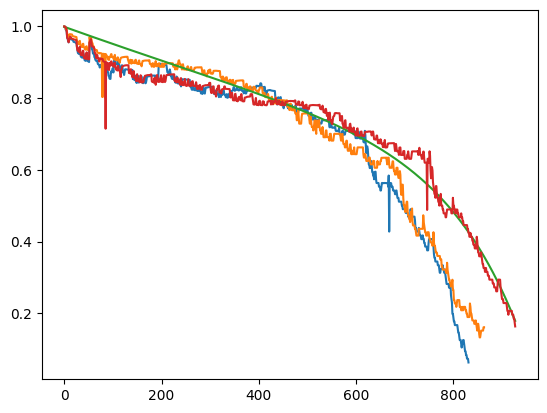

In [34]:
plt.plot(yyy,X1[0])

plt.plot(yyy_1,X2[0])

plt.plot(yyy_2,yyy_curve_fit2)
plt.plot(yyy_2,X3[0])

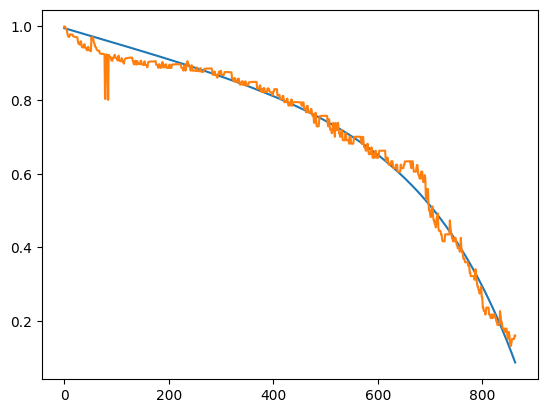

In [35]:
plt.plot(yyy_1,yyy_curve_fit1)
plt.plot(yyy_1,X2[0])

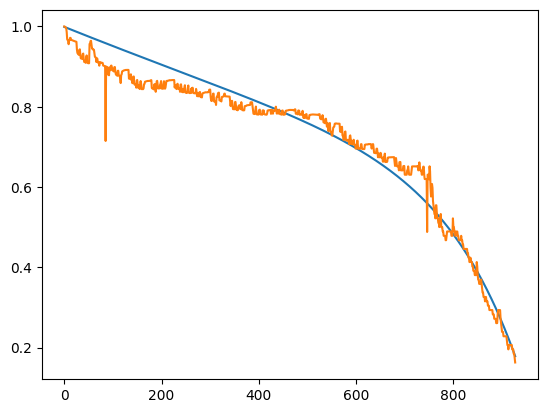

In [36]:
plt.plot(yyy_2,yyy_curve_fit2)
plt.plot(yyy_2,X3[0])

In [37]:
ax = (a+a1+a2)/3
bx = (b+b1+b2)/3
cx = (c+c1+c2)/3

In [38]:
yyy_curve_fit3 = []
for x in yyy_2:
    yyy_curve_fit3.append(a*np.exp(b*x)+c*np.exp(d*x))

[]

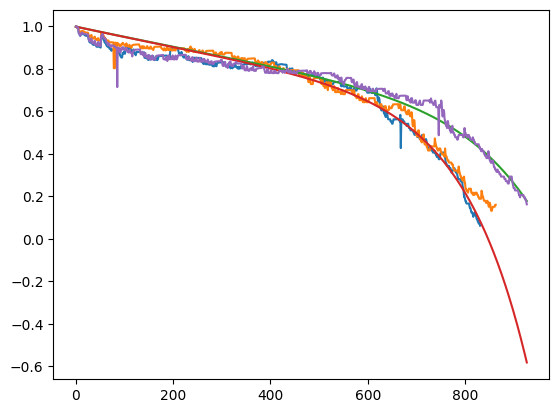

In [39]:
plt.plot(yyy,X1[0])

plt.plot(yyy_1,X2[0])

plt.plot(yyy_2,yyy_curve_fit2)

plt.plot(yyy_2,yyy_curve_fit3)

plt.plot(yyy_2,X3[0])

plt.plot()

In [40]:
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
		# find the end of this pattern
        end_ix = i + n_features
		# check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_input = 32

In [41]:
X1, y1 = prepare_data(X1[0], n_input)
X2, y2 = prepare_data(X2[0], n_input)
X3, y3 = prepare_data(X3[0], n_input)

In [42]:
X2.shape

(832, 32)

In [43]:
X1_ = X1.reshape((X1.shape[0], X1.shape[1], 1))
X2_ = X2.reshape((X2.shape[0], X2.shape[1], 1))
X3_ = X3.reshape((X3.shape[0], X3.shape[1], 1))

from keras.preprocessing.sequence import TimeseriesGenerator

df_rnn = df_rnn.reshape((len(df_rnn), 1))
generated_batches = TimeseriesGenerator(df_rnn, df_rnn, length=n_input, batch_size=1)

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.LSTM(32, activation='selu', input_shape=(n_input, 1),return_sequences=True))
model_rnn.add(keras.layers.LSTM(32, activation='selu', input_shape=(n_input, 1),return_sequences=False))
model_rnn.add(keras.layers.Dense(64, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002)))
model_rnn.add(keras.layers.Dense(32, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002)))
model_rnn.add(keras.layers.Dense(1))

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-3), loss='mse')

In [44]:
k = 0

def expo(y_true,y_pred):
    global k 
    val = y_pred - k - (a * np.exp(b) + c )
    k = y_pred
    print(val + tf.math.abs(y_true-y_pred))
    print(tf.executing_eagerly())
    return val + tf.math.abs(y_true-y_pred)

    

        

In [45]:
def function(x):
    return (a*(x**2) + b*(x)+ c)

In [46]:
def huber_fn(y_true, y_pred):

    error = y_true - y_pred
    is_small_error = tensorflow.abs(error) < 1
    squared_loss = tensorflow.square(error) / 2 
    linear_loss  = tensorflow.abs(error) - 0.5
    print(y_pred.shape)
    print(tf.executing_eagerly())
    return tf.where(is_small_error, squared_loss, linear_loss)

a = (a+a1+a2)/3
b = (b+b1+b2)/3
c = (c+c1+c2)/3

In [47]:
x_1[1][2]

0.9995234755620945

In [48]:
1 in x_1.values

True

In [49]:
from sklearn.metrics import mean_squared_error

cycle_arr = []
theoretical = []

def custom(y_true,y_pred):
    global cycle_arr
    global x_1
    for i in y_true:
        if i in x_1.values:
            cycle_arr.append(x_1[x_1[1]==i][0].iloc[0])
        if i in x_2.values:
            cycle_arr.append(x_2[x_2[1]==i][0].iloc[0])
        if i in x_3.values:
            cycle_arr.append(x_3[x_3[1]==i][0].iloc[0])
    
    if y_true[0] in x_1.values:
        for cycle in cycle_arr:
            theoretical.append([a*np.exp(b*(cycle))+c*np.exp(d*(cycle))])
        rmse = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + rmse
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x1')
        return error

    if y_true[0] in x_2.values:
        for cycle in cycle_arr:
            theoretical.append([a1*np.exp(b1*(cycle))+c1*np.exp(d1*(cycle))])
        rmse = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + rmse
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x2')
        return error

    if y_true[0] in x_3.values:
        for cycle in cycle_arr:
            theoretical.append([a2*np.exp(b2*(cycle))+c2*np.exp(d2*(cycle))])
        rmse = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + rmse
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x3')
        return error


In [50]:
x_2

,0,1
0,0,1.000000
1,1,0.999594
2,2,0.998990
3,3,0.993008
4,4,0.992676
...,...,...
859,859,0.151458
860,860,0.151451
861,861,0.151444
862,862,0.160922


cycle_arr1 = []
theoretical1 = []

def custom1(y_true,y_pred):
    global cycle_arr1
    global x_1
    for i in y_true:
        cycle_arr1.append(x_3[x_3[1]==i][0].iloc[0])
    for cycle in cycle_arr1:
        theoretical1.append([a1*(cycle)**2+b1*(cycle)+c1])
    rmse = tf.math.abs(y_true-y_pred)
    diff = tf.math.abs((y_pred) - np.array(theoretical1))
    error = diff + rmse
    print(tf.executing_eagerly())
    cycle_arr1.clear()
    theoretical1.clear()
    return error
    

cycle_arr2 = []
theoretical2 = []

def custom2(y_true,y_pred):
    global cycle_arr2
    global x_1
    for i in y_true:
        cycle_arr2.append(x_1[x_1[1]==i][0].iloc[0])
    for cycle in cycle_arr2:
        theoretical2.append([a2*(cycle)**2+b2*(cycle)+c2])
    rmse = tf.math.abs(y_true-y_pred)
    diff = tf.math.abs((y_pred) - np.array(theoretical2))
    error = diff + rmse
    print(tf.executing_eagerly())
    cycle_arr2.clear()
    theoretical2.clear()
    return error
    

In [51]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM


from numpy.random import seed
seed(42)



model_rnn = Sequential()
model_rnn.add(LSTM(64,
                return_sequences=False))

model_rnn.add(Dense(16, activation='relu'))

model_rnn.add(Dense(1, activation='linear'))

model_rnn.compile(optimizer='adam', loss=custom, metrics=['mse', 'mae', 'mape'],run_eagerly = True)

Metal device set to: Apple M1


In [52]:
model_rnn.fit(X1_,y1, epochs=30, verbose=1)

Epoch 1/30


2023-07-20 12:38:14.316532: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


True
x1
 1/25 [>.............................] - ETA: 24s - loss: 1.4232 - mse: 0.5525 - mae: 0.7082 - mape: 102.8333True
x1
 2/25 [=>............................] - ETA: 4s - loss: 1.3918 - mse: 0.5267 - mae: 0.6901 - mape: 98.7485  True
x1
 3/25 [==>...........................] - ETA: 3s - loss: 1.3261 - mse: 0.4857 - mae: 0.6576 - mape: 94.6795True
x1
 4/25 [===>..........................] - ETA: 3s - loss: 1.2861 - mse: 0.4556 - mae: 0.6385 - mape: 91.0145True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 1.2555 - mse: 0.4317 - mae: 0.6236 - mape: 87.7778True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 1.2092 - mse: 0.4022 - mae: 0.5993 - mape: 84.4207True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 1.1804 - mse: 0.3815 - mae: 0.5849 - mape: 81.5690True
x1
 8/25 [========>.....................] - ETA: 3s - loss: 1.1422 - mse: 0.3594 - mae: 0.5652 - mape: 78.3867True
x1
 9/25 [=========>....................] - ETA: 3s - loss: 1.1037 - ms

21/25 [========================>.....] - ETA: 0s - loss: 0.0586 - mse: 7.8362e-04 - mae: 0.0200 - mape: 5.6663True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0577 - mse: 7.5902e-04 - mae: 0.0196 - mape: 5.5267True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0569 - mse: 7.3639e-04 - mae: 0.0192 - mape: 5.3964True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0562 - mse: 7.1678e-04 - mae: 0.0190 - mape: 5.3048True
x1
25/25 [==============================] - 5s 181ms/step - loss: 0.0558 - mse: 6.9535e-04 - mae: 0.0187 - mape: 5.1769
Epoch 4/30
True
x1
 1/25 [>.............................] - ETA: 4s - loss: 0.0381 - mse: 2.0923e-04 - mae: 0.0117 - mape: 2.9577True
x1
 2/25 [=>............................] - ETA: 3s - loss: 0.0470 - mse: 3.5518e-04 - mae: 0.0160 - mape: 3.7045True
x1
 3/25 [==>...........................] - ETA: 3s - loss: 0.0481 - mse: 4.5088e-04 - mae: 0.0182 - mape: 3.4731True
x1
 4/25 [===>..........................]

15/25 [=================>............] - ETA: 1s - loss: 0.0421 - mse: 3.6362e-04 - mae: 0.0145 - mape: 3.0716True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0421 - mse: 3.4739e-04 - mae: 0.0141 - mape: 2.9434True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0417 - mse: 3.3270e-04 - mae: 0.0137 - mape: 2.8337True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0417 - mse: 3.3397e-04 - mae: 0.0137 - mape: 2.8227True
x1
19/25 [=====================>........] - ETA: 0s - loss: 0.0419 - mse: 3.3764e-04 - mae: 0.0138 - mape: 2.8658True
x1
20/25 [=======================>......] - ETA: 0s - loss: 0.0416 - mse: 3.3155e-04 - mae: 0.0137 - mape: 2.8658True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0414 - mse: 3.2693e-04 - mae: 0.0136 - mape: 2.8587True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0413 - mse: 3.1745e-04 - mae: 0.0134 - mape: 2.7907True
x1
23/25 [==========================>...] - ETA: 0s - loss:

 9/25 [=========>....................] - ETA: 2s - loss: 0.0421 - mse: 3.3039e-04 - mae: 0.0147 - mape: 3.2018True
x1
10/25 [===========>..................] - ETA: 2s - loss: 0.0428 - mse: 3.2620e-04 - mae: 0.0147 - mape: 3.1746True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0423 - mse: 3.2123e-04 - mae: 0.0146 - mape: 3.1449True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0419 - mse: 3.1424e-04 - mae: 0.0143 - mape: 3.0806True
x1
13/25 [==============>...............] - ETA: 1s - loss: 0.0421 - mse: 3.2768e-04 - mae: 0.0146 - mape: 3.0301True
x1
14/25 [===============>..............] - ETA: 1s - loss: 0.0421 - mse: 3.3217e-04 - mae: 0.0148 - mape: 3.0161True
x1
15/25 [=================>............] - ETA: 1s - loss: 0.0423 - mse: 3.2619e-04 - mae: 0.0146 - mape: 2.9430True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0426 - mse: 3.2882e-04 - mae: 0.0147 - mape: 2.9248True
x1
17/25 [===================>..........] - ETA: 1s - loss:

 3/25 [==>...........................] - ETA: 3s - loss: 0.0374 - mse: 2.1655e-04 - mae: 0.0111 - mape: 2.8515True
x1
 4/25 [===>..........................] - ETA: 3s - loss: 0.0379 - mse: 3.0437e-04 - mae: 0.0114 - mape: 2.6426True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 0.0376 - mse: 2.7760e-04 - mae: 0.0112 - mape: 2.4630True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 0.0378 - mse: 2.5415e-04 - mae: 0.0109 - mape: 2.3596True
x1
 7/25 [=======>......................] - ETA: 2s - loss: 0.0387 - mse: 2.6600e-04 - mae: 0.0114 - mape: 2.3320True
x1
 8/25 [========>.....................] - ETA: 2s - loss: 0.0390 - mse: 2.6799e-04 - mae: 0.0116 - mape: 2.4160True
x1
 9/25 [=========>....................] - ETA: 2s - loss: 0.0391 - mse: 2.6566e-04 - mae: 0.0117 - mape: 2.4494True
x1
10/25 [===========>..................] - ETA: 2s - loss: 0.0390 - mse: 2.5501e-04 - mae: 0.0114 - mape: 2.3352True
x1
11/25 [============>.................] - ETA: 2s - loss:

22/25 [=========================>....] - ETA: 0s - loss: 0.0400 - mse: 2.3233e-04 - mae: 0.0115 - mape: 2.3823True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0399 - mse: 2.2833e-04 - mae: 0.0114 - mape: 2.3459True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0399 - mse: 2.2965e-04 - mae: 0.0114 - mape: 2.3405True
x1
25/25 [==============================] - 4s 161ms/step - loss: 0.0398 - mse: 2.2847e-04 - mae: 0.0115 - mape: 2.3283
Epoch 15/30
True
x1
 1/25 [>.............................] - ETA: 3s - loss: 0.0456 - mse: 2.2208e-04 - mae: 0.0120 - mape: 1.6520True
x1
 2/25 [=>............................] - ETA: 3s - loss: 0.0459 - mse: 1.9377e-04 - mae: 0.0115 - mape: 1.6146True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 0.0443 - mse: 2.0211e-04 - mae: 0.0116 - mape: 2.3659True
x1
 4/25 [===>..........................] - ETA: 3s - loss: 0.0426 - mse: 1.9311e-04 - mae: 0.0113 - mape: 2.4911True
x1
 5/25 [=====>........................

16/25 [==================>...........] - ETA: 1s - loss: 0.0408 - mse: 2.6703e-04 - mae: 0.0123 - mape: 2.4752True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0411 - mse: 2.6539e-04 - mae: 0.0123 - mape: 2.4904True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0411 - mse: 2.5707e-04 - mae: 0.0121 - mape: 2.4778True
x1
19/25 [=====================>........] - ETA: 0s - loss: 0.0409 - mse: 2.5425e-04 - mae: 0.0121 - mape: 2.4387True
x1
20/25 [=======================>......] - ETA: 0s - loss: 0.0412 - mse: 2.5827e-04 - mae: 0.0122 - mape: 2.4371True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0410 - mse: 2.5480e-04 - mae: 0.0122 - mape: 2.4267True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0417 - mse: 2.5481e-04 - mae: 0.0123 - mape: 2.3991True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0415 - mse: 2.5504e-04 - mae: 0.0123 - mape: 2.4162True
x1
24/25 [===========================>..] - ETA: 0s - loss:

10/25 [===========>..................] - ETA: 2s - loss: 0.0415 - mse: 2.7748e-04 - mae: 0.0131 - mape: 2.3514True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0409 - mse: 2.7055e-04 - mae: 0.0129 - mape: 2.3876True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0420 - mse: 2.8209e-04 - mae: 0.0133 - mape: 2.4400True
x1
13/25 [==============>...............] - ETA: 1s - loss: 0.0417 - mse: 2.8795e-04 - mae: 0.0134 - mape: 2.4713True
x1
14/25 [===============>..............] - ETA: 1s - loss: 0.0416 - mse: 2.8579e-04 - mae: 0.0134 - mape: 2.4572True
x1
15/25 [=================>............] - ETA: 1s - loss: 0.0421 - mse: 3.3517e-04 - mae: 0.0140 - mape: 2.6467True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0423 - mse: 3.4168e-04 - mae: 0.0143 - mape: 2.6262True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0421 - mse: 3.3443e-04 - mae: 0.0141 - mape: 2.6207True
x1
18/25 [====================>.........] - ETA: 1s - loss:

 4/25 [===>..........................] - ETA: 3s - loss: 0.0412 - mse: 3.2708e-04 - mae: 0.0123 - mape: 2.1987True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 0.0399 - mse: 2.9728e-04 - mae: 0.0119 - mape: 2.3242True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 0.0404 - mse: 3.1770e-04 - mae: 0.0128 - mape: 2.5110True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 0.0416 - mse: 3.5319e-04 - mae: 0.0140 - mape: 2.7857True
x1
 8/25 [========>.....................] - ETA: 2s - loss: 0.0414 - mse: 3.4075e-04 - mae: 0.0139 - mape: 2.6739True
x1
 9/25 [=========>....................] - ETA: 2s - loss: 0.0411 - mse: 3.2760e-04 - mae: 0.0136 - mape: 2.6340True
x1
10/25 [===========>..................] - ETA: 2s - loss: 0.0413 - mse: 3.1296e-04 - mae: 0.0134 - mape: 2.6149True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0410 - mse: 3.0108e-04 - mae: 0.0132 - mape: 2.5653True
x1
12/25 [=============>................] - ETA: 2s - loss:

23/25 [==========================>...] - ETA: 0s - loss: 0.0408 - mse: 2.6327e-04 - mae: 0.0124 - mape: 2.4068True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0410 - mse: 2.7258e-04 - mae: 0.0126 - mape: 2.4229True
x1
25/25 [==============================] - 4s 173ms/step - loss: 0.0410 - mse: 2.6748e-04 - mae: 0.0125 - mape: 2.3955
Epoch 26/30
True
x1
 1/25 [>.............................] - ETA: 4s - loss: 0.0497 - mse: 3.0113e-04 - mae: 0.0139 - mape: 2.6691True
x1
 2/25 [=>............................] - ETA: 3s - loss: 0.0462 - mse: 2.9528e-04 - mae: 0.0142 - mape: 2.8203True
x1
 3/25 [==>...........................] - ETA: 3s - loss: 0.0437 - mse: 2.7187e-04 - mae: 0.0135 - mape: 2.5927True
x1
 4/25 [===>..........................] - ETA: 3s - loss: 0.0430 - mse: 2.7198e-04 - mae: 0.0135 - mape: 2.4485True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 0.0430 - mse: 2.9335e-04 - mae: 0.0142 - mape: 2.4223True
x1
 6/25 [======>.......................

17/25 [===================>..........] - ETA: 1s - loss: 0.0413 - mse: 2.9874e-04 - mae: 0.0135 - mape: 2.5794True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0414 - mse: 2.9242e-04 - mae: 0.0134 - mape: 2.5724True
x1
19/25 [=====================>........] - ETA: 1s - loss: 0.0416 - mse: 2.8830e-04 - mae: 0.0133 - mape: 2.5512True
x1
20/25 [=======================>......] - ETA: 0s - loss: 0.0416 - mse: 2.8431e-04 - mae: 0.0132 - mape: 2.5468True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0416 - mse: 2.8439e-04 - mae: 0.0132 - mape: 2.5317True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0417 - mse: 2.8111e-04 - mae: 0.0132 - mape: 2.4950True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0418 - mse: 2.7691e-04 - mae: 0.0131 - mape: 2.4786True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0418 - mse: 2.7414e-04 - mae: 0.0130 - mape: 2.4661True
x1
25/25 [==============================] - 4s 170ms/step -

In [53]:
model_rnn.fit(X2_,y2, epochs=30, verbose=1)

Epoch 1/30
True
x2
 1/26 [>.............................] - ETA: 4s - loss: 0.0234 - mse: 1.0388e-04 - mae: 0.0084 - mape: 1.2332True
x2
 2/26 [=>............................] - ETA: 4s - loss: 0.0237 - mse: 1.1860e-04 - mae: 0.0081 - mape: 1.3608True
x2
 3/26 [==>...........................] - ETA: 3s - loss: 0.0293 - mse: 1.8152e-04 - mae: 0.0100 - mape: 1.9800True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0307 - mse: 1.9541e-04 - mae: 0.0103 - mape: 1.9853True
x2
 5/26 [====>.........................] - ETA: 3s - loss: 0.0313 - mse: 2.0538e-04 - mae: 0.0107 - mape: 1.9919True
x2
 6/26 [=====>........................] - ETA: 3s - loss: 0.0327 - mse: 2.3050e-04 - mae: 0.0115 - mape: 2.0005True
x2
 7/26 [=======>......................] - ETA: 3s - loss: 0.0316 - mse: 2.1051e-04 - mae: 0.0109 - mape: 1.8785True
x2
 8/26 [========>.....................] - ETA: 3s - loss: 0.0325 - mse: 2.1482e-04 - mae: 0.0112 - mape: 1.9160True
x2
 9/26 [=========>....................

18/26 [===================>..........] - ETA: 1s - loss: 0.0291 - mse: 2.1534e-04 - mae: 0.0106 - mape: 1.8776True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0291 - mse: 2.3117e-04 - mae: 0.0107 - mape: 1.9251True
x2
20/26 [======================>.......] - ETA: 1s - loss: 0.0292 - mse: 2.2660e-04 - mae: 0.0106 - mape: 1.8973True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0286 - mse: 2.1973e-04 - mae: 0.0105 - mape: 1.8605True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0284 - mse: 2.1637e-04 - mae: 0.0104 - mape: 1.8506True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0284 - mse: 2.1374e-04 - mae: 0.0104 - mape: 1.8619True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0283 - mse: 2.0835e-04 - mae: 0.0103 - mape: 1.8395True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0282 - mse: 2.0525e-04 - mae: 0.0102 - mape: 1.8315True
x2
26/26 [==============================] - 5s 189ms/step -

 8/26 [========>.....................] - ETA: 3s - loss: 0.0309 - mse: 2.5121e-04 - mae: 0.0119 - mape: 2.0698True
x2
 9/26 [=========>....................] - ETA: 3s - loss: 0.0319 - mse: 2.6195e-04 - mae: 0.0125 - mape: 2.0892True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0306 - mse: 2.4197e-04 - mae: 0.0119 - mape: 1.9732True
x2
11/26 [===========>..................] - ETA: 2s - loss: 0.0306 - mse: 2.5381e-04 - mae: 0.0123 - mape: 2.0533True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0305 - mse: 2.5381e-04 - mae: 0.0124 - mape: 2.0555True
x2
13/26 [==============>...............] - ETA: 2s - loss: 0.0302 - mse: 2.4804e-04 - mae: 0.0122 - mape: 2.0297True
x2
14/26 [===============>..............] - ETA: 2s - loss: 0.0303 - mse: 2.4235e-04 - mae: 0.0121 - mape: 2.0259True
x2
15/26 [================>.............] - ETA: 2s - loss: 0.0301 - mse: 2.3606e-04 - mae: 0.0119 - mape: 2.0159True
x2
16/26 [=================>............] - ETA: 2s - loss:

25/26 [===========================>..] - ETA: 0s - loss: 0.0282 - mse: 1.8965e-04 - mae: 0.0101 - mape: 1.8671True
x2
26/26 [==============================] - 6s 247ms/step - loss: 0.0281 - mse: 2.0190e-04 - mae: 0.0101 - mape: 1.8583
Epoch 9/30
True
x2
 1/26 [>.............................] - ETA: 5s - loss: 0.0326 - mse: 1.7622e-04 - mae: 0.0104 - mape: 1.9451True
x2
 2/26 [=>............................] - ETA: 4s - loss: 0.0331 - mse: 2.1682e-04 - mae: 0.0119 - mape: 2.1136True
x2
 3/26 [==>...........................] - ETA: 3s - loss: 0.0348 - mse: 3.1578e-04 - mae: 0.0147 - mape: 2.3247True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0345 - mse: 3.0003e-04 - mae: 0.0144 - mape: 2.3673True
x2
 5/26 [====>.........................] - ETA: 3s - loss: 0.0331 - mse: 2.6542e-04 - mae: 0.0133 - mape: 2.1817True
x2
 6/26 [=====>........................] - ETA: 3s - loss: 0.0330 - mse: 2.7622e-04 - mae: 0.0133 - mape: 2.2005True
x2
 7/26 [=======>......................]

16/26 [=================>............] - ETA: 1s - loss: 0.0289 - mse: 2.4666e-04 - mae: 0.0110 - mape: 1.9092True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0294 - mse: 2.5456e-04 - mae: 0.0112 - mape: 1.9845True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0302 - mse: 2.6533e-04 - mae: 0.0116 - mape: 2.0641True
x2
19/26 [====================>.........] - ETA: 0s - loss: 0.0301 - mse: 2.5783e-04 - mae: 0.0114 - mape: 2.0323True
x2
20/26 [======================>.......] - ETA: 0s - loss: 0.0304 - mse: 2.6644e-04 - mae: 0.0118 - mape: 2.0543True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0309 - mse: 2.7762e-04 - mae: 0.0122 - mape: 2.0941True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0305 - mse: 2.6992e-04 - mae: 0.0120 - mape: 2.0699True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0307 - mse: 2.7279e-04 - mae: 0.0122 - mape: 2.0829True
x2
24/26 [==========================>...] - ETA: 0s - loss:

 7/26 [=======>......................] - ETA: 3s - loss: 0.0244 - mse: 1.0981e-04 - mae: 0.0081 - mape: 1.4936True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0249 - mse: 1.6161e-04 - mae: 0.0086 - mape: 1.5075True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0247 - mse: 1.5571e-04 - mae: 0.0085 - mape: 1.5059True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0247 - mse: 1.4890e-04 - mae: 0.0084 - mape: 1.4726True
x2
11/26 [===========>..................] - ETA: 2s - loss: 0.0249 - mse: 1.4597e-04 - mae: 0.0085 - mape: 1.4828True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0251 - mse: 1.4160e-04 - mae: 0.0084 - mape: 1.4471True
x2
13/26 [==============>...............] - ETA: 2s - loss: 0.0253 - mse: 1.4406e-04 - mae: 0.0087 - mape: 1.4982True
x2
14/26 [===============>..............] - ETA: 1s - loss: 0.0253 - mse: 1.4682e-04 - mae: 0.0088 - mape: 1.5435True
x2
15/26 [================>.............] - ETA: 1s - loss:

24/26 [==========================>...] - ETA: 0s - loss: 0.0266 - mse: 1.8440e-04 - mae: 0.0093 - mape: 1.7047True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0267 - mse: 1.8356e-04 - mae: 0.0093 - mape: 1.7215True
x2
26/26 [==============================] - 4s 158ms/step - loss: 0.0268 - mse: 1.8419e-04 - mae: 0.0094 - mape: 1.7153
Epoch 17/30
True
x2
 1/26 [>.............................] - ETA: 3s - loss: 0.0264 - mse: 1.4175e-04 - mae: 0.0091 - mape: 1.5390True
x2
 2/26 [=>............................] - ETA: 3s - loss: 0.0276 - mse: 1.8415e-04 - mae: 0.0099 - mape: 1.7857True
x2
 3/26 [==>...........................] - ETA: 3s - loss: 0.0279 - mse: 1.5666e-04 - mae: 0.0091 - mape: 1.7094True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0265 - mse: 1.4822e-04 - mae: 0.0091 - mape: 1.6751True
x2
 5/26 [====>.........................] - ETA: 3s - loss: 0.0263 - mse: 1.5329e-04 - mae: 0.0094 - mape: 1.7630True
x2
 6/26 [=====>........................

15/26 [================>.............] - ETA: 1s - loss: 0.0283 - mse: 2.3086e-04 - mae: 0.0103 - mape: 1.8618True
x2
16/26 [=================>............] - ETA: 1s - loss: 0.0281 - mse: 2.2375e-04 - mae: 0.0102 - mape: 1.8279True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0279 - mse: 2.1876e-04 - mae: 0.0102 - mape: 1.8084True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0280 - mse: 2.1387e-04 - mae: 0.0101 - mape: 1.7909True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0278 - mse: 2.1265e-04 - mae: 0.0102 - mape: 1.7947True
x2
20/26 [======================>.......] - ETA: 0s - loss: 0.0280 - mse: 2.1093e-04 - mae: 0.0102 - mape: 1.7758True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0284 - mse: 2.1441e-04 - mae: 0.0103 - mape: 1.8180True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0282 - mse: 2.0988e-04 - mae: 0.0102 - mape: 1.8027True
x2
23/26 [=========================>....] - ETA: 0s - loss:

 6/26 [=====>........................] - ETA: 3s - loss: 0.0266 - mse: 1.3209e-04 - mae: 0.0092 - mape: 1.8357True
x2
 7/26 [=======>......................] - ETA: 2s - loss: 0.0265 - mse: 1.2531e-04 - mae: 0.0088 - mape: 1.7205True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0268 - mse: 1.2831e-04 - mae: 0.0090 - mape: 1.7450True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0264 - mse: 1.2641e-04 - mae: 0.0090 - mape: 1.7313True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0266 - mse: 1.2732e-04 - mae: 0.0089 - mape: 1.7154True
x2
11/26 [===========>..................] - ETA: 2s - loss: 0.0269 - mse: 1.3765e-04 - mae: 0.0092 - mape: 1.8246True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0272 - mse: 1.6361e-04 - mae: 0.0095 - mape: 1.8414True
x2
13/26 [==============>...............] - ETA: 2s - loss: 0.0272 - mse: 1.6486e-04 - mae: 0.0095 - mape: 1.8551True
x2
14/26 [===============>..............] - ETA: 1s - loss:

23/26 [=========================>....] - ETA: 0s - loss: 0.0268 - mse: 1.8797e-04 - mae: 0.0095 - mape: 1.7775True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0268 - mse: 1.8564e-04 - mae: 0.0095 - mape: 1.7761True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0268 - mse: 1.8357e-04 - mae: 0.0095 - mape: 1.7711True
x2
26/26 [==============================] - 4s 158ms/step - loss: 0.0270 - mse: 1.8407e-04 - mae: 0.0095 - mape: 1.7545
Epoch 25/30
True
x2
 1/26 [>.............................] - ETA: 3s - loss: 0.0231 - mse: 9.9792e-05 - mae: 0.0080 - mape: 1.6190True
x2
 2/26 [=>............................] - ETA: 3s - loss: 0.0230 - mse: 1.0403e-04 - mae: 0.0083 - mape: 1.5190True
x2
 3/26 [==>...........................] - ETA: 3s - loss: 0.0266 - mse: 3.1309e-04 - mae: 0.0107 - mape: 1.9939True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0278 - mse: 2.6251e-04 - mae: 0.0101 - mape: 1.8191True
x2
 5/26 [====>.........................

14/26 [===============>..............] - ETA: 1s - loss: 0.0287 - mse: 1.8520e-04 - mae: 0.0105 - mape: 1.7811True
x2
15/26 [================>.............] - ETA: 1s - loss: 0.0284 - mse: 1.8039e-04 - mae: 0.0104 - mape: 1.7910True
x2
16/26 [=================>............] - ETA: 1s - loss: 0.0285 - mse: 1.8057e-04 - mae: 0.0104 - mape: 1.7756True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0284 - mse: 1.7779e-04 - mae: 0.0104 - mape: 1.8089True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0282 - mse: 1.7505e-04 - mae: 0.0103 - mape: 1.7858True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0283 - mse: 1.7587e-04 - mae: 0.0103 - mape: 1.7681True
x2
20/26 [======================>.......] - ETA: 0s - loss: 0.0283 - mse: 1.7851e-04 - mae: 0.0104 - mape: 1.7936True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0285 - mse: 1.9804e-04 - mae: 0.0104 - mape: 1.7886True
x2
22/26 [========================>.....] - ETA: 0s - loss:

 5/26 [====>.........................] - ETA: 3s - loss: 0.0299 - mse: 2.4489e-04 - mae: 0.0109 - mape: 1.7935True
x2
 6/26 [=====>........................] - ETA: 3s - loss: 0.0285 - mse: 2.1664e-04 - mae: 0.0102 - mape: 1.7397True
x2
 7/26 [=======>......................] - ETA: 2s - loss: 0.0282 - mse: 2.0884e-04 - mae: 0.0102 - mape: 1.7605True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0278 - mse: 1.9999e-04 - mae: 0.0101 - mape: 1.7383True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0279 - mse: 2.0621e-04 - mae: 0.0106 - mape: 1.8001True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0281 - mse: 2.0993e-04 - mae: 0.0108 - mape: 1.8278True
x2
11/26 [===========>..................] - ETA: 2s - loss: 0.0278 - mse: 2.0526e-04 - mae: 0.0106 - mape: 1.7990True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0283 - mse: 2.0922e-04 - mae: 0.0107 - mape: 1.7958True
x2
13/26 [==============>...............] - ETA: 2s - loss:

In [54]:
model_rnn.fit(X3_,y3, epochs=30, verbose=1)

Epoch 1/30
True
x3
 1/28 [>.............................] - ETA: 4s - loss: 0.0362 - mse: 2.2385e-04 - mae: 0.0114 - mape: 1.9450True
x3
 2/28 [=>............................] - ETA: 4s - loss: 0.0366 - mse: 1.6535e-04 - mae: 0.0102 - mape: 1.7536True
x3
 3/28 [==>...........................] - ETA: 3s - loss: 0.0373 - mse: 1.5409e-04 - mae: 0.0099 - mape: 1.7090True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0364 - mse: 1.3500e-04 - mae: 0.0092 - mape: 1.5552True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0356 - mse: 1.4155e-04 - mae: 0.0093 - mape: 1.6222True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0361 - mse: 1.4224e-04 - mae: 0.0092 - mape: 1.5695True
x3
 7/28 [======>.......................] - ETA: 3s - loss: 0.0359 - mse: 1.4586e-04 - mae: 0.0092 - mape: 1.5281True
x3
 8/28 [=======>......................] - ETA: 3s - loss: 0.0361 - mse: 1.4900e-04 - mae: 0.0093 - mape: 1.5495True
x3
 9/28 [========>.....................

14/28 [==============>...............] - ETA: 2s - loss: 0.0371 - mse: 3.1623e-04 - mae: 0.0113 - mape: 1.7360True
x3
15/28 [===============>..............] - ETA: 2s - loss: 0.0370 - mse: 3.1100e-04 - mae: 0.0113 - mape: 1.7390True
x3
16/28 [================>.............] - ETA: 1s - loss: 0.0370 - mse: 3.0666e-04 - mae: 0.0113 - mape: 1.7559True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0369 - mse: 2.9956e-04 - mae: 0.0113 - mape: 1.7485True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0368 - mse: 2.9156e-04 - mae: 0.0113 - mape: 1.7382True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0365 - mse: 2.8767e-04 - mae: 0.0113 - mape: 1.7290True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0367 - mse: 2.8268e-04 - mae: 0.0112 - mape: 1.7150True
x3
21/28 [=====================>........] - ETA: 1s - loss: 0.0368 - mse: 2.7799e-04 - mae: 0.0112 - mape: 1.7090True
x3
22/28 [======================>.......] - ETA: 0s - loss:

27/28 [===========================>..] - ETA: 0s - loss: 0.0390 - mse: 3.4161e-04 - mae: 0.0134 - mape: 2.0343True
x3
28/28 [==============================] - 5s 164ms/step - loss: 0.0388 - mse: 3.3485e-04 - mae: 0.0132 - mape: 2.0095
Epoch 6/30
True
x3
 1/28 [>.............................] - ETA: 4s - loss: 0.0395 - mse: 2.4638e-04 - mae: 0.0133 - mape: 2.3304True
x3
 2/28 [=>............................] - ETA: 4s - loss: 0.0403 - mse: 1.9426e-04 - mae: 0.0115 - mape: 1.9115True
x3
 3/28 [==>...........................] - ETA: 4s - loss: 0.0379 - mse: 1.9940e-04 - mae: 0.0113 - mape: 1.9688True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0388 - mse: 2.6895e-04 - mae: 0.0129 - mape: 2.0673True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0409 - mse: 6.0473e-04 - mae: 0.0152 - mape: 2.3418True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0407 - mse: 5.3589e-04 - mae: 0.0145 - mape: 2.2249True
x3
 7/28 [======>.......................]

12/28 [===========>..................] - ETA: 2s - loss: 0.0376 - mse: 3.8743e-04 - mae: 0.0127 - mape: 1.9757True
x3
13/28 [============>.................] - ETA: 2s - loss: 0.0378 - mse: 3.7436e-04 - mae: 0.0126 - mape: 1.9681True
x3
14/28 [==============>...............] - ETA: 2s - loss: 0.0373 - mse: 3.5807e-04 - mae: 0.0124 - mape: 1.9397True
x3
15/28 [===============>..............] - ETA: 2s - loss: 0.0371 - mse: 3.4785e-04 - mae: 0.0123 - mape: 1.9148True
x3
16/28 [================>.............] - ETA: 1s - loss: 0.0370 - mse: 3.4499e-04 - mae: 0.0123 - mape: 1.9290True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0369 - mse: 3.3351e-04 - mae: 0.0121 - mape: 1.8863True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0370 - mse: 3.2389e-04 - mae: 0.0121 - mape: 1.8876True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0369 - mse: 3.1492e-04 - mae: 0.0119 - mape: 1.8574True
x3
20/28 [====================>.........] - ETA: 1s - loss:

25/28 [=========================>....] - ETA: 0s - loss: 0.0361 - mse: 2.8733e-04 - mae: 0.0121 - mape: 1.8551True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0362 - mse: 2.9357e-04 - mae: 0.0123 - mape: 1.8854True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0363 - mse: 3.1058e-04 - mae: 0.0124 - mape: 1.9187True
x3
28/28 [==============================] - 5s 169ms/step - loss: 0.0363 - mse: 3.0488e-04 - mae: 0.0123 - mape: 1.8913
Epoch 11/30
True
x3
 1/28 [>.............................] - ETA: 4s - loss: 0.0309 - mse: 1.2873e-04 - mae: 0.0089 - mape: 1.3027True
x3
 2/28 [=>............................] - ETA: 4s - loss: 0.0343 - mse: 8.2658e-04 - mae: 0.0123 - mape: 2.0330True
x3
 3/28 [==>...........................] - ETA: 5s - loss: 0.0374 - mse: 6.2109e-04 - mae: 0.0120 - mape: 1.9727True
x3
 4/28 [===>..........................] - ETA: 5s - loss: 0.0367 - mse: 5.0908e-04 - mae: 0.0115 - mape: 1.8027True
x3
 5/28 [====>.........................

 9/28 [========>.....................] - ETA: 4s - loss: 0.0369 - mse: 3.2707e-04 - mae: 0.0131 - mape: 1.9867True
x3
10/28 [=========>....................] - ETA: 4s - loss: 0.0369 - mse: 3.2769e-04 - mae: 0.0131 - mape: 1.9603True
x3
11/28 [==========>...................] - ETA: 4s - loss: 0.0369 - mse: 3.1847e-04 - mae: 0.0130 - mape: 1.9817True
x3
12/28 [===========>..................] - ETA: 3s - loss: 0.0368 - mse: 3.0619e-04 - mae: 0.0128 - mape: 1.9501True
x3
13/28 [============>.................] - ETA: 3s - loss: 0.0363 - mse: 2.9859e-04 - mae: 0.0126 - mape: 1.9261True
x3
14/28 [==============>...............] - ETA: 3s - loss: 0.0363 - mse: 2.9108e-04 - mae: 0.0125 - mape: 1.9430True
x3
15/28 [===============>..............] - ETA: 3s - loss: 0.0364 - mse: 2.8651e-04 - mae: 0.0124 - mape: 1.9366True
x3
16/28 [================>.............] - ETA: 2s - loss: 0.0365 - mse: 2.8313e-04 - mae: 0.0123 - mape: 1.9137True
x3
17/28 [=================>............] - ETA: 2s - loss:

22/28 [======================>.......] - ETA: 1s - loss: 0.0356 - mse: 3.5821e-04 - mae: 0.0130 - mape: 2.0228True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0354 - mse: 3.5458e-04 - mae: 0.0129 - mape: 2.0214True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0355 - mse: 3.4756e-04 - mae: 0.0128 - mape: 2.0112True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0356 - mse: 3.4357e-04 - mae: 0.0128 - mape: 1.9962True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0357 - mse: 3.4935e-04 - mae: 0.0130 - mape: 2.0013True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0357 - mse: 3.4568e-04 - mae: 0.0130 - mape: 1.9914True
x3
28/28 [==============================] - 5s 193ms/step - loss: 0.0356 - mse: 3.4076e-04 - mae: 0.0129 - mape: 1.9815
Epoch 16/30
True
x3
 1/28 [>.............................] - ETA: 6s - loss: 0.0363 - mse: 1.7749e-04 - mae: 0.0109 - mape: 1.4826True
x3
 2/28 [=>............................

 7/28 [======>.......................] - ETA: 3s - loss: 0.0335 - mse: 2.7051e-04 - mae: 0.0113 - mape: 1.8136True
x3
 8/28 [=======>......................] - ETA: 3s - loss: 0.0337 - mse: 2.6990e-04 - mae: 0.0114 - mape: 1.8544True
x3
 9/28 [========>.....................] - ETA: 3s - loss: 0.0341 - mse: 2.6911e-04 - mae: 0.0114 - mape: 1.8570True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0341 - mse: 2.7695e-04 - mae: 0.0117 - mape: 1.9118True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0339 - mse: 2.7916e-04 - mae: 0.0118 - mape: 1.8892True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0343 - mse: 2.7310e-04 - mae: 0.0118 - mape: 1.8639True
x3
13/28 [============>.................] - ETA: 2s - loss: 0.0355 - mse: 3.7287e-04 - mae: 0.0124 - mape: 1.9322True
x3
14/28 [==============>...............] - ETA: 2s - loss: 0.0358 - mse: 3.6843e-04 - mae: 0.0125 - mape: 1.9191True
x3
15/28 [===============>..............] - ETA: 2s - loss:

20/28 [====================>.........] - ETA: 1s - loss: 0.0346 - mse: 3.7573e-04 - mae: 0.0131 - mape: 2.0522True
x3
21/28 [=====================>........] - ETA: 1s - loss: 0.0348 - mse: 3.8433e-04 - mae: 0.0134 - mape: 2.1167True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0349 - mse: 3.8071e-04 - mae: 0.0134 - mape: 2.1229True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0350 - mse: 3.7292e-04 - mae: 0.0133 - mape: 2.0968True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0352 - mse: 3.6635e-04 - mae: 0.0132 - mape: 2.0861True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0353 - mse: 3.6118e-04 - mae: 0.0132 - mape: 2.0649True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0356 - mse: 3.7154e-04 - mae: 0.0135 - mape: 2.1044True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0356 - mse: 3.7081e-04 - mae: 0.0135 - mape: 2.0954True
x3
28/28 [==============================] - 4s 159ms/step -

 5/28 [====>.........................] - ETA: 3s - loss: 0.0343 - mse: 2.5666e-04 - mae: 0.0124 - mape: 1.9026True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0342 - mse: 2.5721e-04 - mae: 0.0123 - mape: 1.8825True
x3
 7/28 [======>.......................] - ETA: 3s - loss: 0.0333 - mse: 2.5621e-04 - mae: 0.0123 - mape: 1.9183True
x3
 8/28 [=======>......................] - ETA: 3s - loss: 0.0343 - mse: 2.6444e-04 - mae: 0.0124 - mape: 1.9634True
x3
 9/28 [========>.....................] - ETA: 3s - loss: 0.0345 - mse: 2.5489e-04 - mae: 0.0123 - mape: 1.9434True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0342 - mse: 2.4559e-04 - mae: 0.0120 - mape: 1.8788True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0345 - mse: 2.5404e-04 - mae: 0.0122 - mape: 1.8785True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0348 - mse: 2.6035e-04 - mae: 0.0124 - mape: 1.9061True
x3
13/28 [============>.................] - ETA: 2s - loss:

18/28 [==================>...........] - ETA: 1s - loss: 0.0353 - mse: 4.1198e-04 - mae: 0.0141 - mape: 2.1448True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0358 - mse: 4.3097e-04 - mae: 0.0145 - mape: 2.1829True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0356 - mse: 4.1972e-04 - mae: 0.0143 - mape: 2.1531True
x3
21/28 [=====================>........] - ETA: 1s - loss: 0.0358 - mse: 4.1296e-04 - mae: 0.0142 - mape: 2.1496True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0358 - mse: 4.0585e-04 - mae: 0.0142 - mape: 2.1397True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0356 - mse: 3.9942e-04 - mae: 0.0141 - mape: 2.1268True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0357 - mse: 4.0547e-04 - mae: 0.0142 - mape: 2.1391True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0358 - mse: 4.1297e-04 - mae: 0.0144 - mape: 2.1736True
x3
26/28 [==========================>...] - ETA: 0s - loss:

 3/28 [==>...........................] - ETA: 3s - loss: 0.0331 - mse: 3.2683e-04 - mae: 0.0139 - mape: 2.1837True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0332 - mse: 3.0381e-04 - mae: 0.0133 - mape: 2.0393True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0327 - mse: 2.7557e-04 - mae: 0.0127 - mape: 1.9870True
x3
 6/28 [=====>........................] - ETA: 3s - loss: 0.0342 - mse: 3.1051e-04 - mae: 0.0135 - mape: 2.0608True
x3
 7/28 [======>.......................] - ETA: 3s - loss: 0.0339 - mse: 3.2223e-04 - mae: 0.0137 - mape: 2.0905True
x3
 8/28 [=======>......................] - ETA: 3s - loss: 0.0341 - mse: 3.4034e-04 - mae: 0.0139 - mape: 2.1055True
x3
 9/28 [========>.....................] - ETA: 3s - loss: 0.0349 - mse: 3.5512e-04 - mae: 0.0144 - mape: 2.1584True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0362 - mse: 4.7934e-04 - mae: 0.0148 - mape: 2.2089True
x3
11/28 [==========>...................] - ETA: 2s - loss:

16/28 [================>.............] - ETA: 1s - loss: 0.0377 - mse: 5.0826e-04 - mae: 0.0157 - mape: 2.3411True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0375 - mse: 4.8966e-04 - mae: 0.0154 - mape: 2.2975True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0372 - mse: 4.7147e-04 - mae: 0.0151 - mape: 2.2678True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0372 - mse: 4.6104e-04 - mae: 0.0150 - mape: 2.2420True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0371 - mse: 4.4494e-04 - mae: 0.0147 - mape: 2.1918True
x3
21/28 [=====================>........] - ETA: 1s - loss: 0.0368 - mse: 4.3055e-04 - mae: 0.0144 - mape: 2.1609True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0367 - mse: 4.2547e-04 - mae: 0.0144 - mape: 2.1681True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0367 - mse: 4.1364e-04 - mae: 0.0142 - mape: 2.1426True
x3
24/28 [========================>.....] - ETA: 0s - loss:

model_rnn = keras.models.load_model('rul_pred_model')

In [55]:
test = data_all['CS2_37']
test = test.dropna()

In [56]:
test

,cycle,charging capacity,CCCT,CVCT,discharging capacity,SoH,resistance
0,1.0,1.161525,6700.402232,2329.575169,1.134322,0.823067,0.095034
1,2.0,1.139045,6584.606466,2250.466820,1.124251,0.825265,0.093494
2,3.0,1.137832,6581.199729,2239.498181,1.123968,0.816053,0.091952
3,4.0,1.137912,6578.870556,2230.982867,1.123611,0.816065,0.092035
4,5.0,1.137219,6573.386562,2257.123247,1.117115,0.806864,0.091868
...,...,...,...,...,...,...,...
1038,1039.0,0.188495,440.476968,2256.508955,0.174207,0.045846,0.121246
1039,1040.0,0.185420,422.461562,2251.430923,0.183388,0.045848,0.122651
1040,1041.0,0.188716,447.791593,2256.805953,0.183400,0.055017,0.121136
1041,1042.0,0.193064,448.523735,2258.728025,0.183400,0.055014,0.119727


In [57]:
test = test['discharging capacity']

In [58]:
test = pd.DataFrame(test)
test = ss.fit_transform(test)

In [59]:
last_train_batch = test[550:582]

last_train_batch = last_train_batch.reshape((1,n_input,1))

In [60]:
model_rnn.predict(last_train_batch)[0]

1/1 [==============================] - 0s 139ms/step


array([0.7784787], dtype=float32)

In [61]:
test[583]

array([0.78330331])

In [62]:
len(test)

1025

test_predictions = []

first_eval_batch = test[500:500+n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(test[500:800])):
    
    # get the prediction value for the first batch
    current_pred = model_rnn.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [63]:
test_predictions = []

test_predictions.extend(test[:n_input])

for i in range(len(test)-n_input+1):
    
    # get the prediction value for the first batch
    
    dummy = test[i:i+n_input].reshape((1, n_input, 1))
    # use the prediction to update the batch and remove the first value
    current_batch = (dummy)
    current_pred = model_rnn.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 



1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


In [64]:
test = ss.inverse_transform(test)
y_pred_future = ss.inverse_transform(test_predictions)

In [65]:
np.array(y_pred_future)

array([[1.13432224],
       [1.12425147],
       [1.12396805],
       ...,
       [0.16574402],
       [0.16645499],
       [0.16700511]])

indexes_test_rnn = np.arange(500,800)
test_predictions = pd.DataFrame(test_predictions, index =indexes_test_rnn)
y_pred_future = pd.DataFrame(y_pred_future, index =indexes_test_rnn)


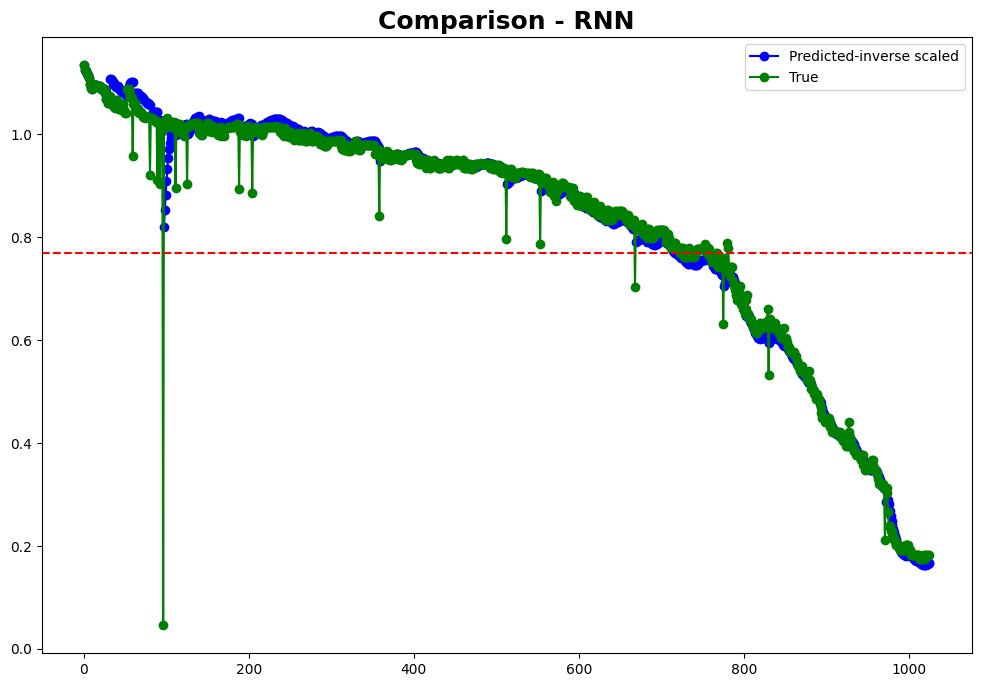

In [66]:
plt.figure(figsize = (12,8))

plt.plot(y_pred_future,linestyle='solid', marker='o', color='b', label='Predicted-inverse scaled')
plt.plot(test,linestyle='solid', marker='o', color='g', label='True')


plt.axhline(y = .7*1.1, color = 'r', linestyle = '--')




plt.title("Comparison - RNN", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [67]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_future[:-1], test, squared=False)

0.03829696568075123

In [68]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM


from numpy.random import seed
seed(42)



opt = keras.optimizers.Adam()
callback = keras.callbacks.EarlyStopping(monitor='loss',patience =3)


model = Sequential()
model.add(LSTM(64,return_sequences=False))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer=opt, loss='mae', metrics=['mse', 'mae', 'mape', keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly = True)

In [69]:
model.fit(X1_,y1, epochs=30, verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 33ms/step - loss: 0.3097 - mse: 0.1724 - mae: 0.3097 - mape: 45.4845 - rmse: 0.4152
Epoch 2/30
25/25 [==============================] - 1s 32ms/step - loss: 0.0471 - mse: 0.0034 - mae: 0.0471 - mape: 11.2123 - rmse: 0.0584
Epoch 3/30
25/25 [==============================] - 1s 33ms/step - loss: 0.0178 - mse: 6.4250e-04 - mae: 0.0178 - mape: 4.9833 - rmse: 0.0253
Epoch 4/30
25/25 [==============================] - 1s 33ms/step - loss: 0.0120 - mse: 2.5529e-04 - mae: 0.0120 - mape: 2.6344 - rmse: 0.0160
Epoch 5/30
25/25 [==============================] - 1s 34ms/step - loss: 0.0116 - mse: 2.3858e-04 - mae: 0.0116 - mape: 2.4444 - rmse: 0.0154
Epoch 6/30
25/25 [==============================] - 1s 33ms/step - loss: 0.0147 - mse: 3.5229e-04 - mae: 0.0147 - mape: 2.8131 - rmse: 0.0188
Epoch 7/30
25/25 [==============================] - 1s 33ms/step - loss: 0.0112 - mse: 2.2476e-04 - mae: 0.0112 - mape: 2.1757 - rmse: 0.0150
Epoch 8/30
2

In [70]:
model.fit(X2_,y2, epochs=30, verbose=1)

Epoch 1/30
26/26 [==============================] - 1s 33ms/step - loss: 0.0116 - mse: 2.5528e-04 - mae: 0.0116 - mape: 2.0233 - rmse: 0.0160
Epoch 2/30
26/26 [==============================] - 1s 33ms/step - loss: 0.0115 - mse: 2.4341e-04 - mae: 0.0115 - mape: 2.0327 - rmse: 0.0156
Epoch 3/30
26/26 [==============================] - 1s 34ms/step - loss: 0.0106 - mse: 2.1516e-04 - mae: 0.0106 - mape: 1.8745 - rmse: 0.0147
Epoch 4/30
26/26 [==============================] - 1s 34ms/step - loss: 0.0099 - mse: 1.9908e-04 - mae: 0.0099 - mape: 1.7997 - rmse: 0.0141
Epoch 5/30
26/26 [==============================] - 1s 34ms/step - loss: 0.0093 - mse: 1.7716e-04 - mae: 0.0093 - mape: 1.7262 - rmse: 0.0133
Epoch 6/30
26/26 [==============================] - 1s 33ms/step - loss: 0.0095 - mse: 1.8614e-04 - mae: 0.0095 - mape: 1.7336 - rmse: 0.0136
Epoch 7/30
26/26 [==============================] - 1s 33ms/step - loss: 0.0090 - mse: 1.7043e-04 - mae: 0.0090 - mape: 1.6575 - rmse: 0.0131
Epoch 

In [71]:
model.fit(X3_,y3, epochs=30, verbose=1)

Epoch 1/30
28/28 [==============================] - 1s 35ms/step - loss: 0.0101 - mse: 2.1819e-04 - mae: 0.0101 - mape: 1.5936 - rmse: 0.0148
Epoch 2/30
28/28 [==============================] - 1s 38ms/step - loss: 0.0087 - mse: 1.7786e-04 - mae: 0.0087 - mape: 1.4228 - rmse: 0.0133
Epoch 3/30
28/28 [==============================] - 1s 40ms/step - loss: 0.0092 - mse: 1.9059e-04 - mae: 0.0092 - mape: 1.4784 - rmse: 0.0138
Epoch 4/30
28/28 [==============================] - 1s 40ms/step - loss: 0.0085 - mse: 1.7809e-04 - mae: 0.0085 - mape: 1.3687 - rmse: 0.0133
Epoch 5/30
28/28 [==============================] - 1s 38ms/step - loss: 0.0090 - mse: 1.8897e-04 - mae: 0.0090 - mape: 1.4613 - rmse: 0.0137
Epoch 6/30
28/28 [==============================] - 1s 37ms/step - loss: 0.0087 - mse: 1.8367e-04 - mae: 0.0087 - mape: 1.4210 - rmse: 0.0136
Epoch 7/30
28/28 [==============================] - 1s 33ms/step - loss: 0.0088 - mse: 1.8019e-04 - mae: 0.0088 - mape: 1.4069 - rmse: 0.0134
Epoch 

In [72]:
test = data_all['CS2_37']
test = test.dropna()

In [73]:
test = test['discharging capacity']
test = pd.DataFrame(test)
test = ss.fit_transform(test)

In [74]:
test_predictions_huber = []

test_predictions_huber.extend(test[:n_input])

for i in range(len(test)-n_input+1):
    
    # get the prediction value for the first batch
    
    dummy = test[i:i+n_input].reshape((1, n_input, 1))
    # use the prediction to update the batch and remove the first value
    current_batch = (dummy)
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_huber.append(current_pred) 



1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


In [75]:
test = ss.inverse_transform(test)
y_pred_future_huber = ss.inverse_transform(test_predictions_huber)

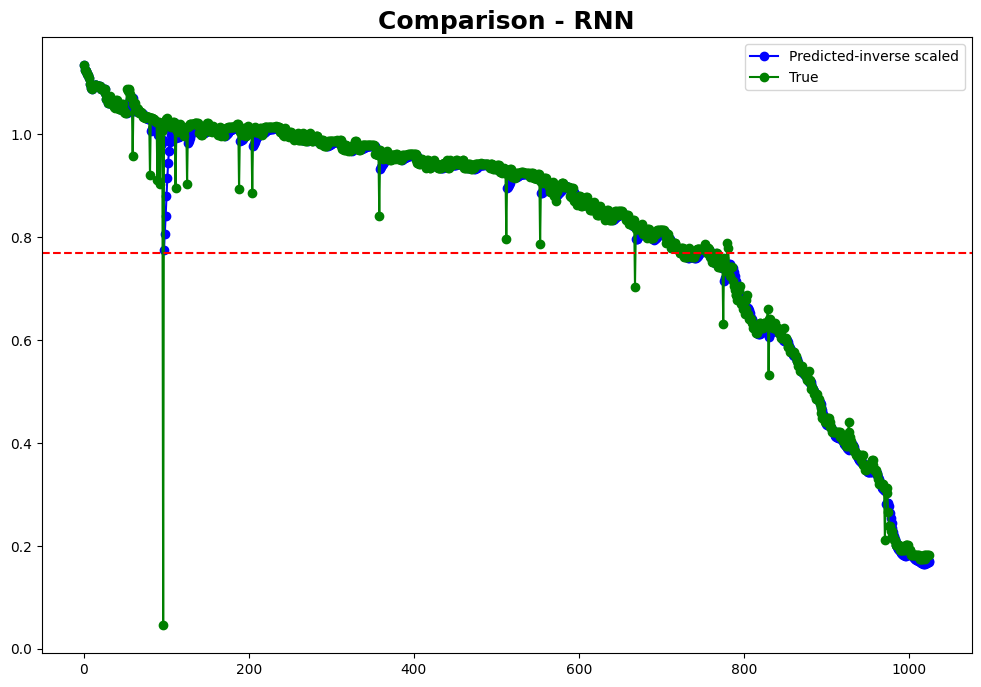

In [76]:
plt.figure(figsize = (12,8))

plt.plot(y_pred_future_huber,linestyle='solid', marker='o', color='b', label='Predicted-inverse scaled')
plt.plot(test,linestyle='solid', marker='o', color='g', label='True')


plt.axhline(y = .7*1.1, color = 'r', linestyle = '--')




plt.title("Comparison - RNN", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [77]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_future_huber[:-1], test, squared=False)

0.03670443711576109

In [78]:
mse_custom = []
for k in range(len(test)):
    mse_custom.append(mean_squared_error(y_pred_future[k],test[k]))
    
mse_huber = []
for k in range(len(test)):
    mse_huber.append(mean_squared_error(y_pred_future_huber[k],test[k]))

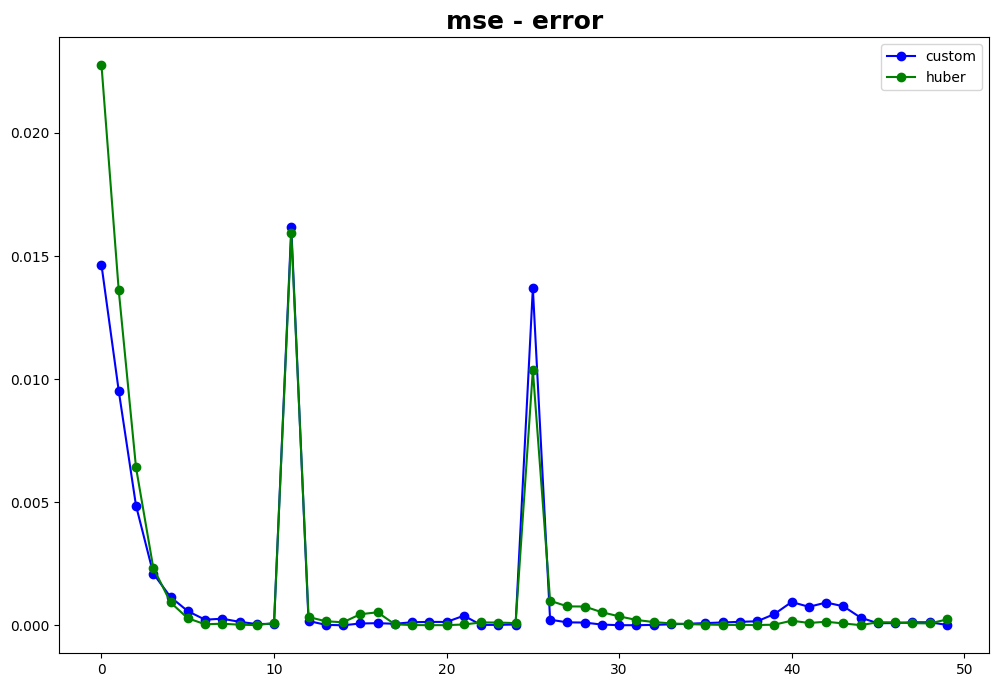

In [79]:
plt.figure(figsize = (12,8))

plt.plot(mse_custom[100:150],linestyle='solid', marker='o', color='b', label='custom')
plt.plot(mse_huber[100:150],linestyle='solid', marker='o', color='g', label='huber')






plt.title("mse - error", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

### RUL

In [80]:
from utility import drop_outlier_sw

name = battery_list[1]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t1 = battery['cycle']
y1 = battery['discharging capacity']


rolling_window = 20
idx = drop_outlier_sw(y1, rolling_window)

t1 = np.array(t1[idx])
y1 = np.array(y1[idx])



name = battery_list[0]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t2 = battery['cycle']
y2 = battery['discharging capacity']

rolling_window = 20
idx = drop_outlier_sw(y2, rolling_window)

t2 = np.array(t2[idx])
y2 = np.array(y2[idx])



name = battery_list[3]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t3 = battery['cycle']
y3 = battery['discharging capacity']

rolling_window = 20
idx = drop_outlier_sw(y3, rolling_window)

t3 = np.array(t3[idx])
y3 = np.array(y3[idx])

In [81]:
true_ttf1, idx_ttf1 = cal_ttf(t1, y1, .7*1.1)
true_ttf2, idx_ttf2 = cal_ttf(t2, y2, .7*1.1)
true_ttf3, idx_ttf3 = cal_ttf(t3, y3, .7*1.1)


In [82]:
initial_rul1 = true_ttf1 - 32
initial_rul2 = true_ttf2 - 32
initial_rul3 = true_ttf3 - 32


In [83]:
### calculate RUL on sliding window

window_size = n_input = 32

X1 = []
Y1 = []

k=0
j=0

window_cycle = initial_rul1
while window_cycle > 0:
    window_cycle = initial_rul1-k
    window = np.array(y1[j:j+window_size])
    k+=1
    j+=1
    X1.append(window)
    Y1.append(window_cycle)
    
X1 = np.array(X1)
Y1 = np.array(Y1)


##############
X2 = []
Y2 = []

k=0
j=0

window_cycle = initial_rul2
while window_cycle > 0:
    window_cycle = initial_rul2-k
    window = np.array(y2[j:j+window_size])
    k+=1
    j+=1
    X2.append(window)
    Y2.append(window_cycle)
    
X2 = np.array(X2)
Y2 = np.array(Y2)

#############

X3 = []
Y3 = []

k=0
j=0

window_cycle = initial_rul3
while window_cycle > 0:
    window_cycle = initial_rul3-k
    window = np.array(y3[j:j+window_size])
    k+=1
    j+=1
    X3.append(window)
    Y3.append(window_cycle)
    
X3 = np.array(X3)
Y3 = np.array(Y3)



In [84]:
from sklearn.preprocessing import MinMaxScaler

ss1 = MinMaxScaler()
ss2 = MinMaxScaler()
ss3 = MinMaxScaler()

Y1 = pd.DataFrame(Y1)
Y1 = ss1.fit_transform(Y1)

Y2 = pd.DataFrame(Y2)
Y2 = ss1.fit_transform(Y2)

Y3 = pd.DataFrame(Y3)
Y3 = ss1.fit_transform(Y3)

In [85]:
X1 = X1[:608]
Y1 = Y1[:608]

X1 = X1.reshape((X1.shape[0], X1.shape[1], 1))
Y1 = Y1.reshape(Y1.shape[0],1)

X2 = X2[:608]
Y2 = Y2[:608]
X2 = X2.reshape((X2.shape[0], X2.shape[1], 1))
Y2 = Y2.reshape(Y2.shape[0],1)

X3 = X3[:768]
Y3 = Y3[:768]
X3 = X3.reshape((X3.shape[0], X3.shape[1], 1))
Y3 = Y3.reshape(Y3.shape[0],1)

    val = y_pred - m
    m = y_pred
    print(m)
    print(val+ tf.math.abs(y_true-y_pred))

In [86]:
len(X3)

768

In [87]:
m = 0

def loss(y_true,y_pred):
    global m 
    val = y_pred - m
    m = y_pred
    print((val))
    print(tensorflow.executing_eagerly())
    return (val) + tensorflow.math.abs((y_true-y_pred))

In [88]:
def huber_fn(y_true, y_pred):
    global m 
    val = y_pred - m
    m = y_true
    error = y_true - y_pred
    is_small_error = tensorflow.abs(error) < 1 + val
    squared_loss = tensorflow.square(error) / 2 + tensorflow.square(val)
    linear_loss  = tensorflow.abs(error) - 0.5
    print(tensorflow.executing_eagerly())
    return tensorflow.where(is_small_error, squared_loss, linear_loss)

In [89]:
def penalty(y_true,y_pred):
    a = 15
    b = 10
    err = y_true-y_pred
    is_negative_error = err < 0
    print(err)
    print(tensorflow.executing_eagerly())
    under = tensorflow.math.exp((-err/a))-1
    over = tensorflow.math.exp((err/b))-1
    print(over)
    print(tensorflow.executing_eagerly())
    return tf.where(is_negative_error, under, over)

In [90]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM, Dropout, BatchNormalization, Bidirectional


from numpy.random import seed
seed(42)



opt = tensorflow.keras.optimizers.Adam()
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',patience =3)


model_rul = Sequential()
model_rul.add((LSTM(16,return_sequences=False)))
model_rul.add(Dense(8, activation='relu'))
model_rul.add(Dense(1, activation='relu'))

model_rul.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae', 'mape', tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly = True)

In [91]:
model_rul.fit(X1,Y1, epochs=20, verbose=2)

Epoch 1/20
19/19 - 1s - loss: 0.0820 - mse: 0.0820 - mae: 0.2409 - mape: 94.1383 - rmse: 0.2864 - 802ms/epoch - 42ms/step
Epoch 2/20
19/19 - 1s - loss: 0.0593 - mse: 0.0593 - mae: 0.2119 - mape: 86.9216 - rmse: 0.2436 - 535ms/epoch - 28ms/step
Epoch 3/20
19/19 - 1s - loss: 0.0575 - mse: 0.0575 - mae: 0.2083 - mape: 86.4186 - rmse: 0.2397 - 531ms/epoch - 28ms/step
Epoch 4/20
19/19 - 1s - loss: 0.0552 - mse: 0.0552 - mae: 0.2051 - mape: 87.5513 - rmse: 0.2350 - 546ms/epoch - 29ms/step
Epoch 5/20
19/19 - 1s - loss: 0.0517 - mse: 0.0517 - mae: 0.1986 - mape: 83.7690 - rmse: 0.2275 - 555ms/epoch - 29ms/step
Epoch 6/20
19/19 - 1s - loss: 0.0477 - mse: 0.0477 - mae: 0.1906 - mape: 79.5700 - rmse: 0.2185 - 550ms/epoch - 29ms/step
Epoch 7/20
19/19 - 1s - loss: 0.0427 - mse: 0.0427 - mae: 0.1813 - mape: 75.0058 - rmse: 0.2067 - 551ms/epoch - 29ms/step
Epoch 8/20
19/19 - 1s - loss: 0.0343 - mse: 0.0343 - mae: 0.1629 - mape: 66.1510 - rmse: 0.1852 - 560ms/epoch - 29ms/step
Epoch 9/20
19/19 - 1s - 

In [92]:
model_rul.fit(X2,Y2, epochs=20, verbose=2)

Epoch 1/20
19/19 - 1s - loss: 0.0129 - mse: 0.0129 - mae: 0.0944 - mape: 28.3615 - rmse: 0.1135 - 531ms/epoch - 28ms/step
Epoch 2/20
19/19 - 1s - loss: 0.0065 - mse: 0.0065 - mae: 0.0642 - mape: 17.1516 - rmse: 0.0804 - 539ms/epoch - 28ms/step
Epoch 3/20
19/19 - 1s - loss: 0.0055 - mse: 0.0055 - mae: 0.0575 - mape: 13.2429 - rmse: 0.0743 - 536ms/epoch - 28ms/step
Epoch 4/20
19/19 - 1s - loss: 0.0063 - mse: 0.0063 - mae: 0.0606 - mape: 13.8221 - rmse: 0.0795 - 537ms/epoch - 28ms/step
Epoch 5/20
19/19 - 1s - loss: 0.0060 - mse: 0.0060 - mae: 0.0599 - mape: 13.6789 - rmse: 0.0775 - 537ms/epoch - 28ms/step
Epoch 6/20
19/19 - 1s - loss: 0.0058 - mse: 0.0058 - mae: 0.0589 - mape: 13.4444 - rmse: 0.0764 - 527ms/epoch - 28ms/step
Epoch 7/20
19/19 - 1s - loss: 0.0058 - mse: 0.0058 - mae: 0.0592 - mape: 14.0251 - rmse: 0.0763 - 523ms/epoch - 28ms/step
Epoch 8/20
19/19 - 1s - loss: 0.0052 - mse: 0.0052 - mae: 0.0555 - mape: 12.4894 - rmse: 0.0719 - 527ms/epoch - 28ms/step
Epoch 9/20
19/19 - 1s - 

In [93]:
model_rul.fit(X3,Y3, epochs=20, verbose=2)

Epoch 1/20
24/24 - 1s - loss: 0.0026 - mse: 0.0026 - mae: 0.0401 - mape: 14.2519 - rmse: 0.0507 - 663ms/epoch - 28ms/step
Epoch 2/20
24/24 - 1s - loss: 0.0013 - mse: 0.0013 - mae: 0.0289 - mape: 11.2742 - rmse: 0.0362 - 655ms/epoch - 27ms/step
Epoch 3/20
24/24 - 1s - loss: 9.9820e-04 - mse: 9.9820e-04 - mae: 0.0253 - mape: 10.4841 - rmse: 0.0316 - 659ms/epoch - 27ms/step
Epoch 4/20
24/24 - 1s - loss: 9.5137e-04 - mse: 9.5137e-04 - mae: 0.0249 - mape: 10.4002 - rmse: 0.0308 - 661ms/epoch - 28ms/step
Epoch 5/20
24/24 - 1s - loss: 9.2737e-04 - mse: 9.2737e-04 - mae: 0.0246 - mape: 10.4959 - rmse: 0.0305 - 654ms/epoch - 27ms/step
Epoch 6/20
24/24 - 1s - loss: 9.6389e-04 - mse: 9.6389e-04 - mae: 0.0252 - mape: 10.4828 - rmse: 0.0310 - 657ms/epoch - 27ms/step
Epoch 7/20
24/24 - 1s - loss: 9.3500e-04 - mse: 9.3500e-04 - mae: 0.0247 - mape: 10.4373 - rmse: 0.0306 - 664ms/epoch - 28ms/step
Epoch 8/20
24/24 - 1s - loss: 8.9933e-04 - mse: 8.9933e-04 - mae: 0.0244 - mape: 10.4159 - rmse: 0.0300 - 

In [94]:
y_pred_future = np.array(y_pred_future)
test = np.array(test)

In [95]:
cycle = np.arange(1,len(y_pred_future))

In [96]:
true_test, idx_test = cal_ttf(cycle, y_pred_future,  .7*1.1)

In [97]:
true_test

720

In [98]:

rul_test = true_test - 32
rul_test

y_test = []
k=0

window_cycle = rul_test
while window_cycle > 0:
    window_cycle = rul_test-k
    y_test.append(window_cycle)
    k+=1
    
y_test = np.array(y_test)


In [99]:
rul_predictions = []

k=0
j=0

first_eval_batch = y_pred_future[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(y_pred_future[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


In [100]:
rul_pred = ss1.inverse_transform(rul_predictions)

In [101]:
rul_predictions

[array([1.0341822], dtype=float32),
 array([1.0395249], dtype=float32),
 array([1.0425056], dtype=float32),
 array([1.0453727], dtype=float32),
 array([1.0475558], dtype=float32),
 array([1.0492092], dtype=float32),
 array([1.0500534], dtype=float32),
 array([1.0503138], dtype=float32),
 array([1.0506414], dtype=float32),
 array([1.051055], dtype=float32),
 array([1.0515677], dtype=float32),
 array([1.0512615], dtype=float32),
 array([1.050327], dtype=float32),
 array([1.0489663], dtype=float32),
 array([1.0472504], dtype=float32),
 array([1.0454175], dtype=float32),
 array([1.0438864], dtype=float32),
 array([1.0426011], dtype=float32),
 array([1.0409693], dtype=float32),
 array([1.0389869], dtype=float32),
 array([1.0367719], dtype=float32),
 array([1.0343677], dtype=float32),
 array([1.0342917], dtype=float32),
 array([1.0353665], dtype=float32),
 array([1.0375663], dtype=float32),
 array([1.0406275], dtype=float32),
 array([1.0438526], dtype=float32),
 array([1.0470291], dtype=floa

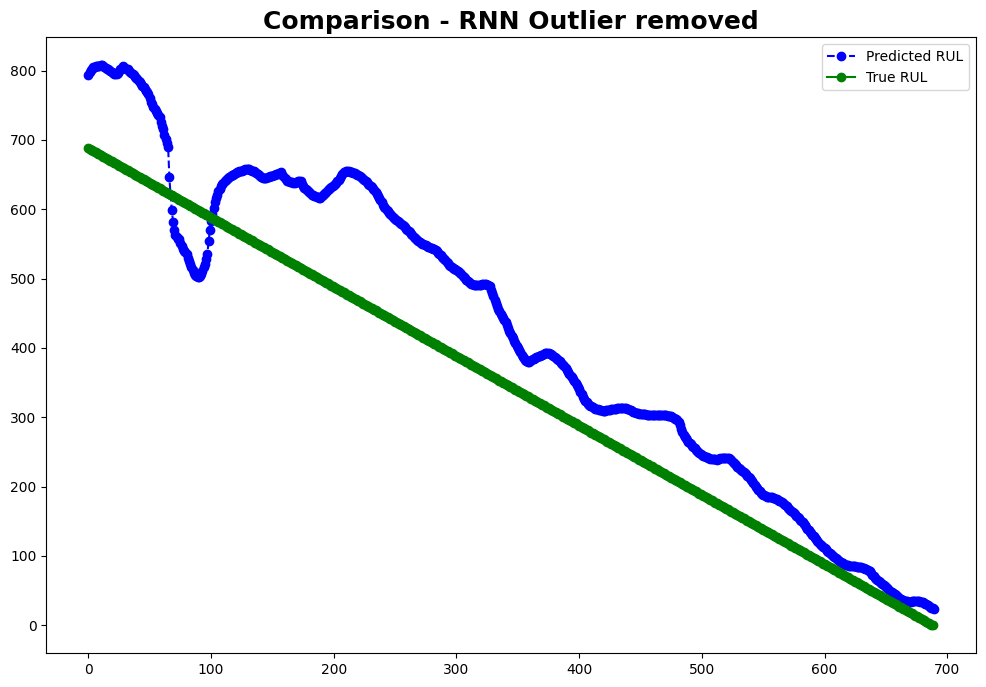

In [102]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [103]:
y_pred_future_huber = np.array(y_pred_future_huber)
test = np.array(test)
cycle = np.arange(1,len(y_pred_future_huber))
true_test, idx_test = cal_ttf(cycle, y_pred_future_huber,  .7*1.1)

In [104]:
true_test

732

In [105]:
rul_predictions_custom = []

k=0
j=0

first_eval_batch = y_pred_future_huber[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(y_pred_future_huber[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions_custom.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


In [106]:
rul_pred_custom = ss1.inverse_transform(rul_predictions_custom)

In [107]:
rul_predictions_custom

[array([1.0341822], dtype=float32),
 array([1.0285534], dtype=float32),
 array([1.0239944], dtype=float32),
 array([1.0196455], dtype=float32),
 array([1.0151253], dtype=float32),
 array([1.010656], dtype=float32),
 array([1.0059634], dtype=float32),
 array([1.0012563], dtype=float32),
 array([0.9971517], dtype=float32),
 array([0.99364275], dtype=float32),
 array([0.9907339], dtype=float32),
 array([0.9874491], dtype=float32),
 array([0.98383504], dtype=float32),
 array([0.98002976], dtype=float32),
 array([0.9760527], dtype=float32),
 array([0.9721021], dtype=float32),
 array([0.9685783], dtype=float32),
 array([0.9654353], dtype=float32),
 array([0.9620678], dtype=float32),
 array([0.95840997], dtype=float32),
 array([0.9545317], dtype=float32),
 array([0.9504623], dtype=float32),
 array([0.94876474], dtype=float32),
 array([0.9484145], dtype=float32),
 array([0.9494133], dtype=float32),
 array([0.95146865], dtype=float32),
 array([0.95382124], dtype=float32),
 array([0.95621866], d

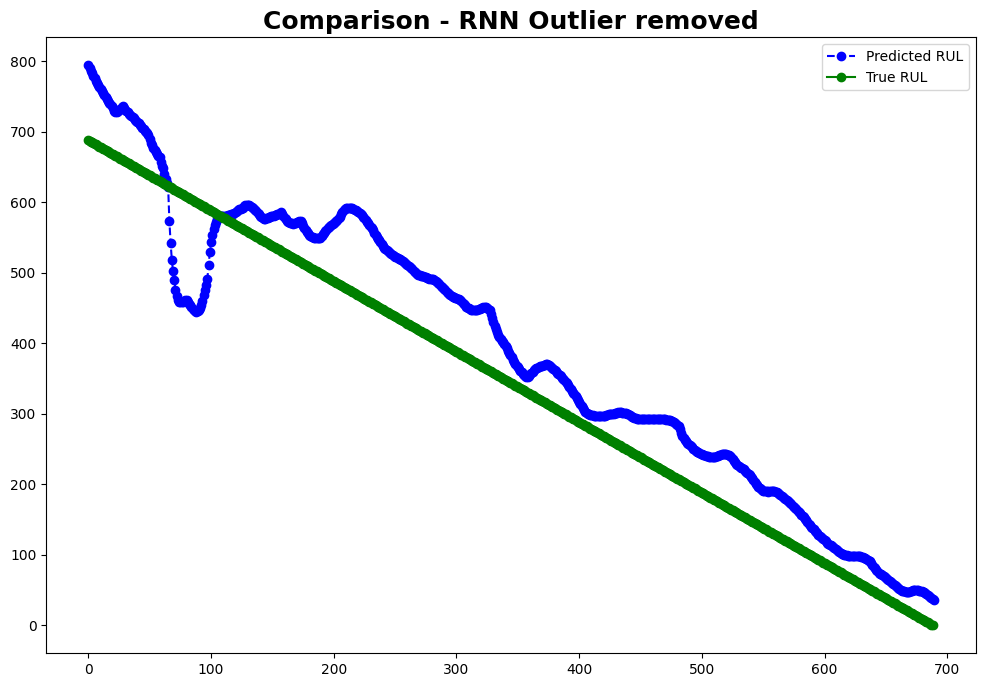

In [108]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred_custom,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [109]:
rul_predictions_test = []

k=0
j=0

first_eval_batch = test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(test[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions_test.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


In [110]:
rul_predictions_test = ss1.inverse_transform(rul_predictions_test)

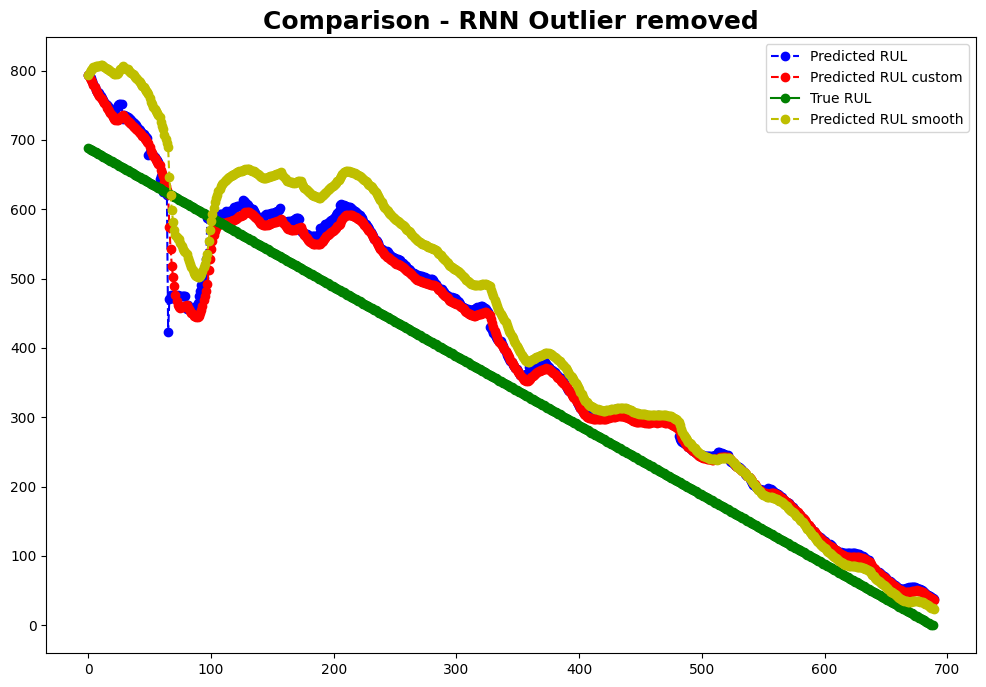

In [111]:
plt.figure(figsize = (12,8))

plt.plot(rul_predictions_test,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Predicted RUL custom')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.plot(rul_pred,linestyle='--', marker='o', color='y', label='Predicted RUL smooth')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [112]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, rul_predictions_test[:-1], squared=False)


70.19262544066048

In [113]:
### NEURAL FILTERED

mean_squared_error(y_test, rul_pred[:-1], squared=False)

95.2607244129889

In [114]:
### NEURAL FILTERED custom loss



%load_ext jupyternotify



<IPython.core.display.Javascript object>

In [115]:
%%notify


mean_squared_error(y_test, rul_pred_custom[:-1], squared=False)

66.2199036680295

<IPython.core.display.Javascript object>

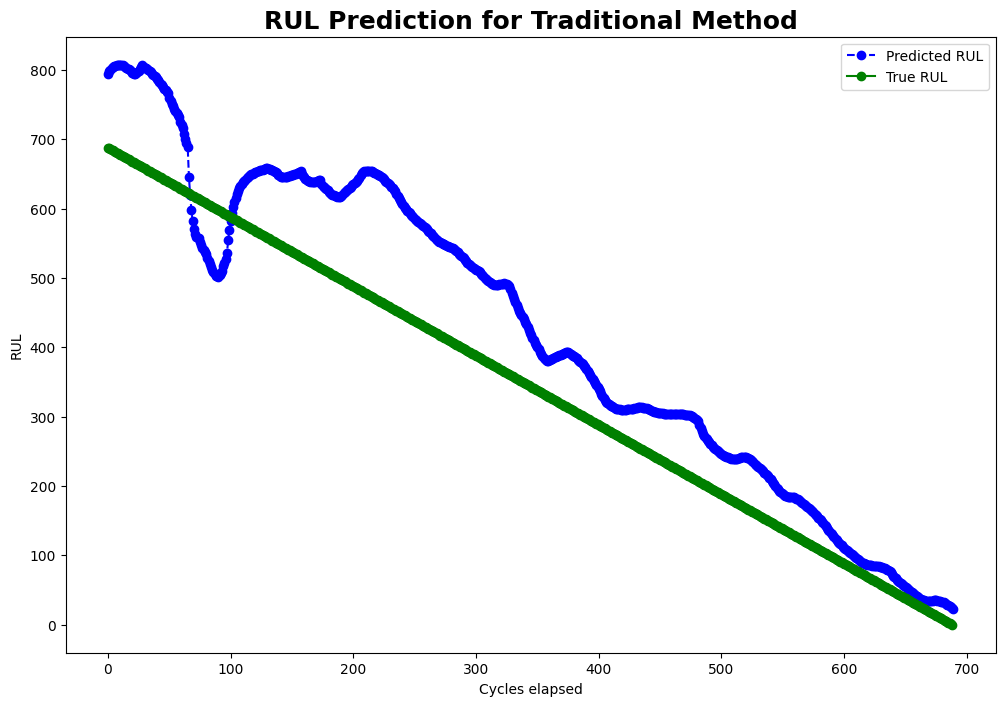

In [116]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')

plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.title("RUL Prediction for Traditional Method", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

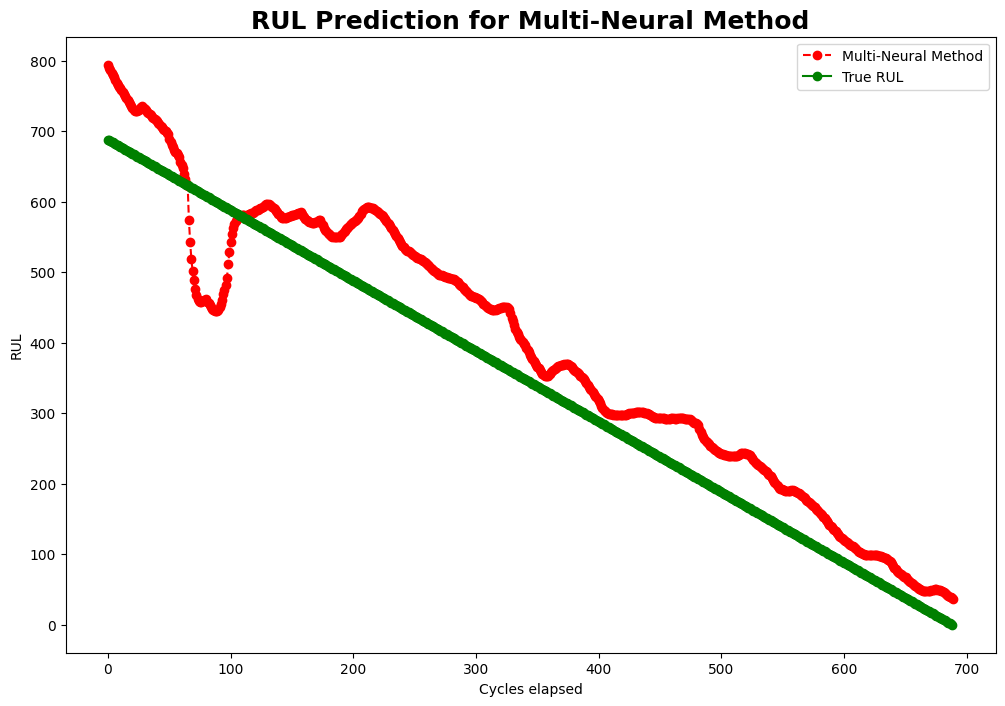

In [117]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Multi-Neural Method')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.title("RUL Prediction for Multi-Neural Method", fontsize=18, fontweight="bold")
plt.legend()


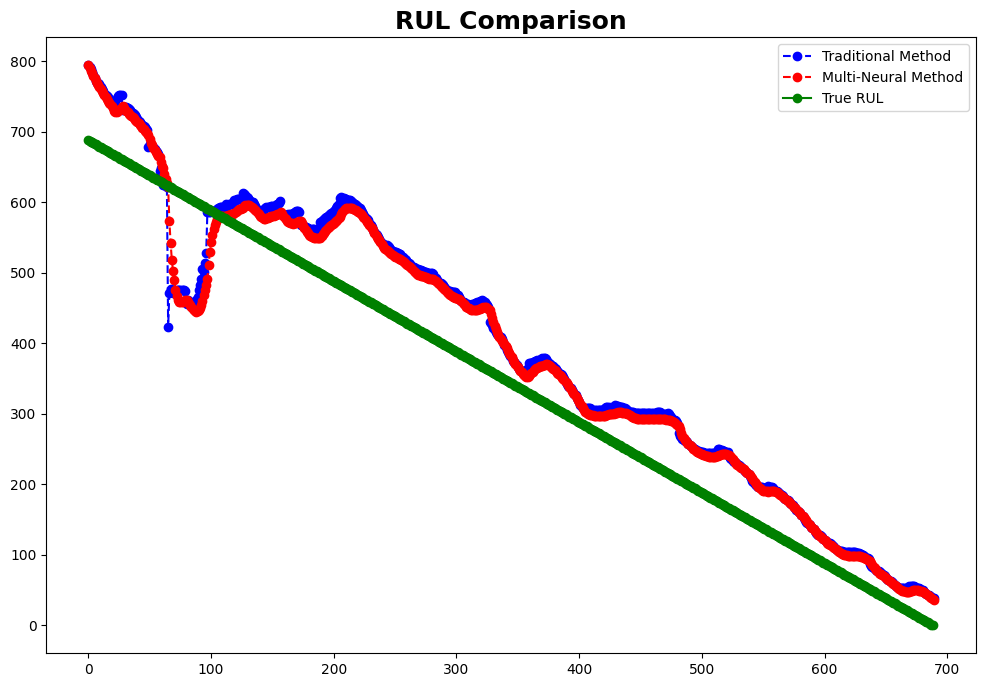

In [118]:
plt.figure(figsize = (12,8))

plt.plot(rul_predictions_test,linestyle='--', marker='o', color='b', label='Traditional Method')
plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Multi-Neural Method')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.title("RUL Comparison", fontsize=18, fontweight="bold")
plt.legend()
